In [4]:
!pip install --upgrade pip
!pip install xgboost scikit-learn==1.2.2 skl2onnx onnxruntime joblib ta seaborn plotly

In [5]:
# 1. --- Imports & GPU check ---
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

# GPU check (Colab): if GPU present, this prints details
print("GPU status (nvidia-smi):")
!nvidia-smi || true

GPU status (nvidia-smi):
Mon Nov  3 13:29:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------

In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset (as provided)
DATA_PATH = '/content/drive/MyDrive/bitcoin/BTC-USD (2014-2024).csv'
MODEL_DIR = '/content/drive/MyDrive/bitcoin/model'
os.makedirs(MODEL_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{name} -> R²: {r2:.6f} | RMSE: {rmse:.6f} | MAPE: {mape:.6f}")
    return {'model': name, 'r2': r2, 'rmse': rmse, 'mape': mape}

def plot_predictions(y_true, y_pred, title='Pred vs True', n_plot=300):
    plt.figure(figsize=(12,5))
    idx = np.arange(len(y_true))
    # plot only last n_plot points to keep readable
    idx = idx[-n_plot:]
    plt.plot(idx, y_true[-n_plot:], label='True', linewidth=1)
    plt.plot(idx, y_pred[-n_plot:], label='Pred', linewidth=1)
    plt.title(title)
    plt.legend()
    plt.show()


In [17]:
df = pd.read_csv(DATA_PATH, parse_dates=True, infer_datetime_format=True)
print("Raw dataset shape:", df.shape)
display(df.head())

# Attempt to detect a timestamp column; common names: 'Date', 'Timestamp', 'datetime', 'time', 'Timestamp(UTC)'
# If you have a timestamp column, adapt the code below to parse it.
timestamp_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
print("Possible timestamp columns:", timestamp_cols)

# If no timestamp column, try to guess 'Date' or create index using row order
if len(timestamp_cols) > 0:
    ts_col = timestamp_cols[0]
    try:
        df[ts_col] = pd.to_datetime(df[ts_col])
        df = df.sort_values(ts_col).reset_index(drop=True)
        df.rename(columns={ts_col: 'datetime'}, inplace=True)
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
    except Exception as e:
        print("Timestamp parse error:", e)
else:
    # Optionally create a synthetic datetime index if not present:
    print("No timestamp column detected. Creating a synthetic datetime index at 1-minute intervals.")
    start = datetime.datetime(2014, 1, 1)
    df.index = pd.date_range(start=start, periods=len(df), freq='T')
    df.index.name = 'datetime'

print("Dataset after timestamp processing:", df.shape)
display(df.head())

Raw dataset shape: (3413, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


Possible timestamp columns: ['Date']
Dataset after timestamp processing: (3413, 6)


,Open,High,Low,Close,Adj Close,Volume
datetime,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [18]:
# 5. --- Data Cleaning & Validation ---
# Common columns in 1-min bitcoin data: 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price'
# Identify columns and standardize names
print("Columns:", df.columns.tolist())

# Normalize column names for convenience (lowercase, strip)
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
df = df.rename(columns={c: c.lower() for c in df.columns})

# Show null counts
print("Null counts:\n", df.isnull().sum())

# 5.a Remove exact duplicates
before = df.shape[0]
df = df[~df.index.duplicated(keep='first')]
after = df.shape[0]
print(f"Removed {before - after} duplicate timestamp rows.")

# 5.b Interpolate or drop missing values
# Strategy:
# - If numeric fields have small gaps, forward/backward fill or interpolate.
# - If large contiguous blocks are missing, either drop those periods or impute with statistical methods.
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

# If there are not too many NaNs, do interpolate then forward/backfill.
df[numeric_cols] = df[numeric_cols].interpolate(method='time').ffill().bfill()

# Drop any remaining NA rows (unlikely)
df = df.dropna(subset=numeric_cols)

print("After interpolation, dataset shape:", df.shape)

# 5.c Outlier handling
# For financial time series, extreme spikes could be real; we will clip values at quantile bounds for numeric stability.
def cap_outliers(series, low_q=0.001, high_q=0.999):
    low = series.quantile(low_q)
    high = series.quantile(high_q)
    return series.clip(lower=low, upper=high)

for col in numeric_cols:
    df[col] = cap_outliers(df[col], low_q=0.001, high_q=0.999)

Columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Null counts:
 open         1
high         1
low          1
close        1
adj_close    1
volume       1
dtype: int64
Removed 0 duplicate timestamp rows.
Numeric columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
After interpolation, dataset shape: (3413, 6)


In [19]:
# 6. --- Feature engineering ---
# Create standard time series features: log returns, moving averages, volatility, volume ratios, hour/day etc.
data = df.copy()

# If 'close' column exists, we will target it. Otherwise attempt to use the last numeric column as target.
target_col = 'close' if 'close' in data.columns else numeric_cols[-1]
print("Target column:", target_col)

# Basic features
data['log_return'] = np.log(data[target_col] / data[target_col].shift(1))
data['return_1m'] = data[target_col].pct_change(1)
data['ma_5'] = data[target_col].rolling(window=5).mean()
data['ma_15'] = data[target_col].rolling(window=15).mean()
data['ma_60'] = data[target_col].rolling(window=60).mean()
data['volatility_60'] = data[target_col].rolling(window=60).std()
# Volume ratio (if volume column exists)
volume_col = None
for cand in ['volume_btc', 'volume', 'volume_(btc)', 'volume_(currency)', 'volume_btc_']:
    if cand in data.columns:
        volume_col = cand
        break

if volume_col:
    data['volume_ratio_60'] = data[volume_col] / data[volume_col].rolling(window=60).mean()
else:
    # if no volume, create synthetic small volume series to avoid dropping feature steps
    data['volume_ratio_60'] = 1.0

# Time components
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['day'] = data.index.day
data['month'] = data.index.month

# Lag features (useful for time series regression)
for lag in [1,2,3,5,10,30,60]:
    data[f'lag_{lag}'] = data[target_col].shift(lag)

# Drop rows with NaNs created by rolling / lag features
data = data.dropna().copy()
print("After feature engineering shape:", data.shape)


Target column: close
After feature engineering shape: (3353, 24)


In [20]:
# 7. --- Prepare X, y (predict next-step close price or next N-step?) ---
# We will predict the next-minute 'close' (shift -1)
HORIZON = 1  # minutes ahead to predict
data['target_next'] = data[target_col].shift(-HORIZON)
data = data.dropna(subset=['target_next'])

feature_cols = [c for c in data.columns if c not in ['target_next']]
# Optionally filter to numeric features only
feature_cols = [c for c in feature_cols if np.issubdtype(data[c].dtype, np.number)]
print("Feature columns used:", feature_cols)

X = data[feature_cols].values
y = data['target_next'].values

print("Final shapes -> X:", X.shape, ", y:", y.shape)

Feature columns used: ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'log_return', 'return_1m', 'ma_5', 'ma_15', 'ma_60', 'volatility_60', 'volume_ratio_60', 'hour', 'dayofweek', 'day', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_30', 'lag_60']
Final shapes -> X: (3352, 24) , y: (3352,)


In [21]:
# 8. --- Train-test split (time series aware) ---
# Use the last 10% as test set (time-ordered)
split_idx = int(0.9 * len(data))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (3016, 24) Test shape: (336, 24)


In [22]:
# 9. --- Modeling pipelines & baseline training ---
# We'll use StandardScaler + model in pipelines
pipelines = {
    'linear': Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    'rf': Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(n_jobs=-1, random_state=42))]),
    'xgb': Pipeline([('scaler', StandardScaler()), ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))])
}

# Quick baseline fit (default hyperparams)
for name, pipe in pipelines.items():
    print("Training", name)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    evaluate_model(name, y_test, preds)


Training linear
linear -> R²: 0.985853 | RMSE: 732.731684 | MAPE: 0.015532
Training rf
rf -> R²: 0.966963 | RMSE: 1119.741588 | MAPE: 0.029020
Training xgb
xgb -> R²: 0.950556 | RMSE: 1369.864584 | MAPE: 0.036131


In [23]:
# 10. --- Hyperparameter tuning (TimeSeriesSplit + RandomizedSearchCV) ---
# Define TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=4)

# Random Forest hyperparam space
rf_param_grid = {
    'rf__n_estimators': [100, 200, 400],
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

# XGBoost hyperparam space (if using GPU, set tree_method='gpu_hist' below)
xgb_param_grid = {
    'xgb__n_estimators': [100, 300, 600],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.6, 0.8, 1.0],
}

# Linear regression (small grid)
lr_param_grid = {
    # no hyperparams for vanilla LinearRegression; but we could add polynomial features or ridge if desired
}

# Randomized search for RandomForest
rf_search = RandomizedSearchCV(
    estimator=pipelines['rf'],
    param_distributions=rf_param_grid,
    n_iter=12,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print("Starting RandomizedSearchCV for RandomForest...")
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_res = evaluate_model("RandomForest_Tuned", y_test, rf_preds)

# Randomized search for XGBoost
# If GPU is present and xgboost supports GPU, set tree_method to 'gpu_hist' in params via 'xgb__tree_method'
# We'll attempt to detect GPU available and set it if possible:
gpu_available = False
try:
    gpu_info = !nvidia-smi --query-gpu=name --format=csv,noheader
    gpu_available = len(gpu_info) > 0 and 'failed' not in ''.join(gpu_info).lower()
except Exception:
    gpu_available = False

if gpu_available:
    print("GPU detected. Will try to use GPU in XGBoost (tree_method='gpu_hist').")
    # update estimator to include GPU option if available
    pipelines['xgb'] = Pipeline([('scaler', StandardScaler()), ('xgb', xgb.XGBRegressor(tree_method='gpu_hist', random_state=42))])
else:
    pipelines['xgb'] = Pipeline([('scaler', StandardScaler()), ('xgb', xgb.XGBRegressor(tree_method='hist', random_state=42))])

xgb_search = RandomizedSearchCV(
    estimator=pipelines['xgb'],
    param_distributions=xgb_param_grid,
    n_iter=12,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print("Starting RandomizedSearchCV for XGBoost...")
xgb_search.fit(X_train, y_train)
print("Best XGB params:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_
xgb_preds = best_xgb.predict(X_test)
xgb_res = evaluate_model("XGBoost_Tuned", y_test, xgb_preds)

# Optionally tune Linear Regression if you want Ridge/Lasso:
from sklearn.linear_model import Ridge
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
ridge_params = {'ridge__alpha': [0.01, 0.1, 1.0, 10.0]}
ridge_search = GridSearchCV(pipe_ridge, ridge_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_search.fit(X_train, y_train)
best_ridge = ridge_search.best_estimator_
ridge_preds = best_ridge.predict(X_test)
ridge_res = evaluate_model("Ridge_Tuned", y_test, ridge_preds)

Starting RandomizedSearchCV for RandomForest...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best RF params: {'rf__n_estimators': 400, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': None}
RandomForest_Tuned -> R²: 0.965951 | RMSE: 1136.771857 | MAPE: 0.029320
GPU detected. Will try to use GPU in XGBoost (tree_method='gpu_hist').
Starting RandomizedSearchCV for XGBoost...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best XGB params: {'xgb__subsample': 0.6, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.05}
XGBoost_Tuned -> R²: 0.966037 | RMSE: 1135.328689 | MAPE: 0.029938
Ridge_Tuned -> R²: 0.985787 | RMSE: 734.437643 | MAPE: 0.015487


In [24]:
# 11. --- Compare & choose best model (by RMSE or R² as you prefer) ---
results = [rf_res, xgb_res, ridge_res]
results_df = pd.DataFrame(results).sort_values('rmse')
display(results_df)

best_model_name = results_df.iloc[0]['model']
print("Best model by RMSE:", best_model_name)

# Map name to actual object
if best_model_name.startswith("RandomForest"):
    final_model = best_rf
elif best_model_name.startswith("XGBoost"):
    final_model = best_xgb
elif best_model_name.startswith("Ridge"):
    final_model = best_ridge
else:
    # fallback to best_rf
    final_model = best_rf

,model,r2,rmse,mape
2,Ridge_Tuned,0.985787,734.437643,0.015487
1,XGBoost_Tuned,0.966037,1135.328689,0.029938
0,RandomForest_Tuned,0.965951,1136.771857,0.029320


Best model by RMSE: Ridge_Tuned


from matplotlib import pyplot as plt
results_df['r2'].plot(kind='hist', bins=20, title='r2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['rmse'].plot(kind='hist', bins=20, title='rmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['mape'].plot(kind='hist', bins=20, title='mape')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='r2', y='rmse', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='rmse', y='mape', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rmse']
  ys = series['r2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('rmse', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rmse')
_ = plt.ylabel('r2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rmse']
  ys = series['mape']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('rmse', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rmse')
_ = plt.ylabel('mape')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rmse']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rmse'}, axis=1)
              .sort_values('rmse', ascending=True))
  xs = counted['rmse']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('rmse', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rmse')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['r2'].plot(kind='line', figsize=(8, 4), title='r2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['rmse'].plot(kind='line', figsize=(8, 4), title='rmse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['mape'].plot(kind='line', figsize=(8, 4), title='mape')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='r2', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='rmse', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='mape', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

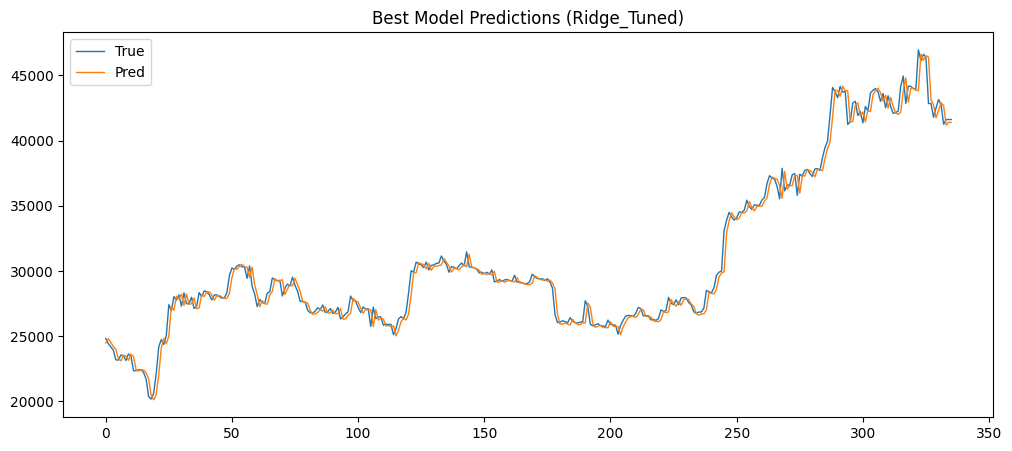

In [25]:
# 12. --- Final evaluation plots ---
if final_model is best_rf:
    final_preds = rf_preds
elif final_model is best_xgb:
    final_preds = xgb_preds
else:
    final_preds = ridge_preds

plot_predictions(y_test, final_preds, title=f"Best Model Predictions ({best_model_name})", n_plot=1000)

In [26]:
# 13. --- Save models: joblib (.pkl) ---
pkl_path = os.path.join(MODEL_DIR, f'best_model_{best_model_name}.pkl')
joblib.dump(final_model, pkl_path)
print("Saved best model to:", pkl_path)

# Save also the scaler/features if needed (pipelines include scaler)
# Save a metadata JSON with features used (so you can prepare new datasets the same way)
import json
meta = {'feature_cols': feature_cols, 'target_col': 'target_next', 'horizon': HORIZON}
with open(os.path.join(MODEL_DIR, 'model_metadata.json'), 'w') as f:
    json.dump(meta, f)
print("Saved model metadata.")

Saved best model to: /content/drive/MyDrive/bitcoin/model/best_model_Ridge_Tuned.pkl
Saved model metadata.


In [27]:
# 14. --- Convert to ONNX for cross-platform usage (best-effort) ---
# ONNX conversion sometimes needs exact estimator type (sklearn). If it's a pipeline with XGBoost, conversion may fail.
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType

    # get example input shape
    sample_input = X_train[:5].astype(np.float32)
    initial_type = [('float_input', FloatTensorType([None, sample_input.shape[1]]))]

    # If final_model is a Pipeline, attempt to convert the step estimator
    # convert_sklearn expects a fitted sklearn-like estimator (pipeline works too if all steps convertible)
    onnx_model = convert_sklearn(final_model, initial_types=initial_type)
    onnx_path = os.path.join(MODEL_DIR, f'best_model_{best_model_name}.onnx')
    with open(onnx_path, 'wb') as f:
        f.write(onnx_model.SerializeToString())
    print("ONNX model saved to:", onnx_path)
except Exception as e:
    print("ONNX conversion failed (this can be expected for some pipelines/models). Error:", e)

ONNX model saved to: /content/drive/MyDrive/bitcoin/model/best_model_Ridge_Tuned.onnx


In [29]:
# 15. --- Function: Load exported model and predict on a NEW dataset ---
def load_model_and_predict(model_path_pkl, new_csv_path, meta_path=None):
    """
    model_path_pkl: path to .pkl model file
    new_csv_path: path to new CSV with same raw columns
    meta_path: optional path to metadata JSON containing 'feature_cols'
    """
    # load model
    model = joblib.load(model_path_pkl)
    new_df = pd.read_csv(new_csv_path, parse_dates=True, infer_datetime_format=True)

    # Basic preprocessing: attempt to create same features as training
    # NOTE: This relies on having the same column names and timestamp-like column
    timestamp_cols = [c for c in new_df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
    if len(timestamp_cols) > 0:
        ts_col = timestamp_cols[0]
        new_df[ts_col] = pd.to_datetime(new_df[ts_col])
        new_df = new_df.sort_values(ts_col).reset_index(drop=True)
        new_df.rename(columns={ts_col: 'datetime'}, inplace=True)
        new_df['datetime'] = pd.to_datetime(new_df['datetime'])
        new_df.set_index('datetime', inplace=True)
    else:
        # if not present, create synthetic index
        new_df.index = pd.date_range(start=datetime.datetime.now(), periods=len(new_df), freq='T')

    # Standardize column names
    new_df.columns = [c.strip().replace(' ', '_').lower() for c in new_df.columns]

    # Generate same feature set
    tcol = 'close' if 'close' in new_df.columns else new_df.select_dtypes(include=[np.number]).columns[-1]
    new_df['log_return'] = np.log(new_df[tcol] / new_df[tcol].shift(1))
    new_df['return_1m'] = new_df[tcol].pct_change(1)
    new_df['ma_5'] = new_df[tcol].rolling(window=5).mean()
    new_df['ma_15'] = new_df[tcol].rolling(window=15).mean()
    new_df['ma_60'] = new_df[tcol].rolling(window=60).mean()
    new_df['volatility_60'] = new_df[tcol].rolling(window=60).std()
    # volume ratio attempt
    vcol = None
    for cand in ['volume_btc', 'volume', 'volume_(btc)', 'volume_(currency)']:
        if cand in new_df.columns:
            vcol = cand
            break
    if vcol:
        new_df['volume_ratio_60'] = new_df[vcol] / new_df[vcol].rolling(window=60).mean()
    else:
        new_df['volume_ratio_60'] = 1.0

    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['day'] = new_df.index.day
    new_df['month'] = new_df.index.month

    for lag in [1,2,3,5,10,30,60]:
        new_df[f'lag_{lag}'] = new_df[tcol].shift(lag)

    new_df = new_df.dropna()
    # Load feature columns from meta if provided
    if meta_path:
        with open(meta_path, 'r') as f:
            md = json.load(f)
        feature_cols_local = md['feature_cols']
    else:
        # fallback choose numeric columns except target
        feature_cols_local = [c for c in new_df.select_dtypes(include=[np.number]).columns if c != tcol]

    X_new = new_df[feature_cols_local].values
    preds = model.predict(X_new)
    new_df['prediction'] = np.nan
    new_df['prediction'].iloc[len(new_df) - len(preds):] = preds
    return new_df[['prediction']].dropna()

# Example usage:
# new_preds = load_model_and_predict(pkl_path, '/content/drive/MyDrive/bitcoin/new_btc_data.csv', meta_path=os.path.join(MODEL_DIR, 'model_metadata.json'))
# display(new_preds.head())

print("All done. Models and metadata saved to:", MODEL_DIR)

All done. Models and metadata saved to: /content/drive/MyDrive/bitcoin/model


In [9]:
# ============================================================
# 🚀 Bitcoin Multi-Timeframe Prediction (Model Metadata Aligned)
# ============================================================

import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from google.colab import drive

# ============================================================
# 1️⃣ Mount Google Drive
# ============================================================
drive.mount('/content/drive', force_remount=True)

base_dir = "/content/drive/MyDrive/bitcoin"
data_path = f"{base_dir}/BTC-USD (2014-2024).csv"
model_path = f"{base_dir}/model/best_model_Ridge_Tuned.pkl"
output_dir = f"{base_dir}/output"
os.makedirs(output_dir, exist_ok=True)

print("✅ Google Drive mounted.")
print(f"✅ Dataset Path: {data_path}")
print(f"✅ Model Path: {model_path}")

# ============================================================
# 2️⃣ Load dataset and model
# ============================================================
try:
    df = pd.read_csv(data_path)
    print(f"✅ BTC dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns.")
except Exception as e:
    raise SystemExit(f"❌ Dataset loading failed: {e}")

try:
    model = joblib.load(model_path)
    print("✅ ML model loaded successfully.")
except Exception as e:
    raise SystemExit(f"❌ Model loading failed: {e}")

# ============================================================
# 3️⃣ Ensure timestamp is proper
# ============================================================
time_col = None
for col in df.columns:
    if col.lower() in ["timestamp", "date", "datetime"]:
        time_col = col
        break

if time_col is None:
    raise ValueError("❌ No Date/Timestamp column found in dataset!")

df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col])
df = df.set_index(time_col)
df = df.sort_index()
df = df.ffill().bfill()

print(f"✅ Time column detected: {time_col}")
print(f"✅ Data indexed by datetime. Range: {df.index.min()} → {df.index.max()}")

# ============================================================
# 4️⃣ Feature Engineering (matches model_metadata)
# ============================================================
def add_features(df):
    data = df.copy()

    # Ensure lowercase columns
    data.columns = [c.lower() for c in data.columns]

    # Basic return features
    data['log_return'] = np.log(data['close'] / data['close'].shift(1))
    data['return_1m'] = data['close'].pct_change()

    # Moving averages
    data['ma_5'] = data['close'].rolling(5).mean()
    data['ma_15'] = data['close'].rolling(15).mean()
    data['ma_60'] = data['close'].rolling(60).mean()

    # Volatility & ratios
    data['volatility_60'] = data['close'].rolling(60).std()
    if 'volume' in data.columns:
        data['volume_ratio_60'] = data['volume'] / data['volume'].rolling(60).mean()
    else:
        data['volume_ratio_60'] = 0

    # Time-based features
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['month'] = data.index.month

    # Lag features
    for lag in [1, 2, 3, 5, 10, 30, 60]:
        data[f'lag_{lag}'] = data['close'].shift(lag)

    # Target
    data['target_next'] = data['close'].shift(-1)

    # Drop NaNs caused by shifting/rolling
    data = data.dropna()

    # Keep only relevant columns from metadata
    feature_cols = [
        "open", "high", "low", "close", "adj_close", "volume", "log_return", "return_1m",
        "ma_5", "ma_15", "ma_60", "volatility_60", "volume_ratio_60", "hour", "dayofweek",
        "day", "month", "lag_1", "lag_2", "lag_3", "lag_5", "lag_10", "lag_30", "lag_60"
    ]

    for col in feature_cols:
        if col not in data.columns:
            data[col] = 0  # add missing columns if not present

    X = data[feature_cols]
    y = data['target_next']
    return X, y

# ============================================================
# 5️⃣ Evaluation Function
# ============================================================
def evaluate_and_plot(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    plt.figure(figsize=(8,4))
    plt.plot(y_true.values[-200:], label="Actual", alpha=0.7)
    plt.plot(y_pred[-200:], label="Predicted", alpha=0.7)
    plt.title(f"{label} Interval Prediction (Last 200 points)")
    plt.legend()
    plt.tight_layout()
    plot_path = f"{output_dir}/performance_plot_{label}.png"
    plt.savefig(plot_path)
    plt.close()

    df_metrics = pd.DataFrame({
        "Interval": [label],
        "R2": [r2],
        "RMSE": [rmse],
        "MAPE": [mape]
    })

    csv_path = f"{output_dir}/evaluation_report_{label}.csv"
    df_metrics.to_csv(csv_path, index=False)
    print(f"✅ {label} done → {csv_path}")
    return df_metrics

# ============================================================
# 6️⃣ Multi-Timeframe Prediction
# ============================================================
intervals = {"5min": "5T", "15min": "15T", "1hour": "1H"}
all_reports = []

for label, rule in intervals.items():
    print(f"\n📊 Processing {label} interval...")
    try:
        df_resampled = df.resample(rule).mean().ffill()
        X, y = add_features(df_resampled)
        preds = model.predict(X)
        report = evaluate_and_plot(y, preds, label)
        all_reports.append(report)
    except Exception as e:
        print(f"⚠️ Error during {label}: {e}")

# ============================================================
# 7️⃣ Combine All Reports
# ============================================================
if all_reports:
    final = pd.concat(all_reports, ignore_index=True)
    final.to_csv(f"{output_dir}/final_evaluation_summary.csv", index=False)
    print(f"\n✅ All evaluations done.")
    print(f"📂 Final Summary → {output_dir}/final_evaluation_summary.csv")
else:
    print("⚠️ No valid results generated.")


Mounted at /content/drive
✅ Google Drive mounted.
✅ Dataset Path: /content/drive/MyDrive/bitcoin/BTC-USD (2014-2024).csv
✅ Model Path: /content/drive/MyDrive/bitcoin/model/best_model_Ridge_Tuned.pkl
✅ BTC dataset loaded: 3413 rows, 7 columns.
✅ ML model loaded successfully.
✅ Time column detected: Date
✅ Data indexed by datetime. Range: 2014-09-18 00:00:00 → 2024-01-21 00:00:00

📊 Processing 5min interval...


/tmp/ipython-input-1931359791.py:159: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(rule).mean().ffill()
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/tmp/ipython-input-1931359791.py:159: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(rule).mean().ffill()


⚠️ Error during 5min: X has 24 features, but Ridge is expecting 8 features as input.

📊 Processing 15min interval...
⚠️ Error during 15min: X has 24 features, but Ridge is expecting 8 features as input.

📊 Processing 1hour interval...
⚠️ Error during 1hour: X has 24 features, but Ridge is expecting 8 features as input.
⚠️ No valid results generated.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/tmp/ipython-input-1931359791.py:159: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample(rule).mean().ffill()
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [10]:
# ============================================================
# 📘 BITCOIN PRICE TRAINING SCRIPT
# Path: /content/drive/MyDrive/bitcoin/notebooks/bitcoin_training.ipynb
# ============================================================

from google.colab import drive
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# ============================================================
# 1️⃣ Mount Google Drive
# ============================================================
drive.mount('/content/drive', force_remount=True)

data_path = '/content/drive/MyDrive/bitcoin/BTC-USD (2014-2024).csv'
model_dir = '/content/drive/MyDrive/bitcoin/model'
os.makedirs(model_dir, exist_ok=True)

print("✅ Google Drive mounted successfully.")
print(f"📁 Dataset Path: {data_path}")

# ============================================================
# 2️⃣ Load Dataset
# ============================================================
df = pd.read_csv(data_path)
print("✅ Dataset loaded successfully!")

# Ensure 'Date' is datetime and sorted
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Drop missing values
df = df.dropna()

# ============================================================
# 3️⃣ Feature Engineering
# ============================================================
df['Price_Change'] = df['Close'].pct_change()
df['High_Low_Range'] = df['High'] - df['Low']
df['Rolling_Mean_5'] = df['Close'].rolling(window=5).mean()
df['Rolling_Mean_20'] = df['Close'].rolling(window=20).mean()
df = df.dropna()

features = ['Open', 'High', 'Low', 'Volume', 'Price_Change', 'High_Low_Range', 'Rolling_Mean_5', 'Rolling_Mean_20']
target = 'Close'

X = df[features]
y = df[target]

# ============================================================
# 4️⃣ Train/Test Split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ============================================================
# 5️⃣ Scaling
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 6️⃣ Model Training with Hyperparameter Tuning
# ============================================================
ridge = Ridge()
params = {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}
grid = GridSearchCV(ridge, params, cv=5)
grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_

# ============================================================
# 7️⃣ Evaluation
# ============================================================
y_pred = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ Best Ridge Alpha: {grid.best_params_['alpha']}")
print(f"📊 R² Score: {r2:.4f}")
print(f"📉 RMSE: {rmse:.4f}")

# ============================================================
# 8️⃣ Save Model and Scaler
# ============================================================
model_path = os.path.join(model_dir, 'best_model_Ridge_Tuned.pkl')
scaler_path = os.path.join(model_dir, 'scaler.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Model saved at: {model_path}")
print(f"✅ Scaler saved at: {scaler_path}")


Mounted at /content/drive
✅ Google Drive mounted successfully.
📁 Dataset Path: /content/drive/MyDrive/bitcoin/BTC-USD (2014-2024).csv
✅ Dataset loaded successfully!
✅ Best Ridge Alpha: 0.1
📊 R² Score: 0.9989
📉 RMSE: 268.3586
✅ Model saved at: /content/drive/MyDrive/bitcoin/model/best_model_Ridge_Tuned.pkl
✅ Scaler saved at: /content/drive/MyDrive/bitcoin/model/scaler.pkl


In [8]:
!ls "/content/drive/MyDrive/bitcoin/notebooks"
